## Sepnet-3
Seperate processing of different sensors.  
One conv layer per sensor with shared weights.  
One conv layer over all sensors.

In [1]:
import pandas as pd
import random
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D, AveragePooling1D, Input, Concatenate, BatchNormalization
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [2]:
df = pd.read_csv("Csv_data/all.csv", index_col=[0])

In [3]:
df

,left_acc_x,left_acc_y,left_acc_z,left_gyr_x,left_gyr_y,left_gyr_z,left_quat_w,left_quat_x,left_quat_y,left_quat_z,...,rtls_mapped_position,rtls_state,rtls_x_filtered,rtls_x_unfiltered,rtls_y_filtered,rtls_y_unfiltered,rtls_z_filtered,rtls_z_unfiltered,label,id
2020-05-26 08:04:14.120,-0.219889,-0.481445,-0.724284,-2.234163,-1.024139,-0.543110,0.669796,0.350221,-0.594804,0.273585,...,-1.0,2.0,3.208845,3.208845,1.387482,1.387482,2.668098,2.668098,0.0,0
2020-05-26 08:04:14.140,0.157715,-0.911621,0.000000,-1.587824,-0.408662,-0.025541,0.682057,0.343657,-0.585584,0.271586,...,-1.0,2.0,3.208845,3.208845,1.387482,1.387482,2.668098,2.668098,0.0,0
2020-05-26 08:04:14.160,0.078125,-0.699219,0.000488,0.219230,0.220295,-0.110679,0.685126,0.340926,-0.582634,0.273695,...,-1.0,2.0,3.208845,3.208845,1.387482,1.387482,2.668098,2.668098,0.0,0
2020-05-26 08:04:14.180,0.116211,-0.741211,-0.258626,0.784689,0.472871,-0.222068,0.678902,0.349042,-0.586143,0.271380,...,-1.0,2.0,3.208845,3.208845,1.387482,1.387482,2.668098,2.668098,0.0,0
2020-05-26 08:04:14.200,-0.110840,-1.037109,-0.567871,2.065661,1.073803,-0.128771,0.663965,0.362933,-0.595742,0.269003,...,-1.0,2.0,3.208845,3.208845,1.387482,1.387482,2.668098,2.668098,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-26 18:07:01.200,-0.580078,-0.984538,-0.343913,0.482094,-4.256191,-1.744975,0.342945,-0.490375,-0.273338,-0.752820,...,-1.0,1.0,3.057509,3.064015,1.384443,1.362724,2.326005,2.519745,0.0,29
2020-05-26 18:07:01.220,-0.625000,-0.854980,-0.353027,-0.045762,-4.401635,-1.484594,0.298254,-0.504422,-0.239510,-0.774104,...,-1.0,1.0,3.057509,3.064015,1.384443,1.362723,2.326005,2.519745,0.0,29
2020-05-26 18:07:01.240,-0.705078,-0.825195,-0.502441,0.068110,-4.489966,-1.493108,0.280677,-0.509885,-0.226557,-0.780615,...,-1.0,1.0,3.057509,3.064015,1.384443,1.362723,2.326005,2.519745,0.0,29
2020-05-26 18:07:01.260,-2.483236,1.871094,-4.249674,5.843660,-0.360063,-2.737187,0.248654,-0.555116,-0.236941,-0.756464,...,-1.0,1.0,3.057509,3.064015,1.384443,1.362724,2.326005,2.519745,0.0,29


In [4]:
df.columns

Index(['left_acc_x', 'left_acc_y', 'left_acc_z', 'left_gyr_x', 'left_gyr_y',
       'left_gyr_z', 'left_quat_w', 'left_quat_x', 'left_quat_y',
       'left_quat_z', 'hip_acc_x', 'hip_acc_y', 'hip_acc_z', 'hip_gyr_x',
       'hip_gyr_y', 'hip_gyr_z', 'hip_quat_w', 'hip_quat_x', 'hip_quat_y',
       'hip_quat_z', 'right_acc_x', 'right_acc_y', 'right_acc_z',
       'right_gyr_x', 'right_gyr_y', 'right_gyr_z', 'right_quat_w',
       'right_quat_x', 'right_quat_y', 'right_quat_z', 'rtls_accuracy',
       'rtls_accuracy_radius', 'rtls_mapped_position', 'rtls_state',
       'rtls_x_filtered', 'rtls_x_unfiltered', 'rtls_y_filtered',
       'rtls_y_unfiltered', 'rtls_z_filtered', 'rtls_z_unfiltered', 'label',
       'id'],
      dtype='object')

# Preprocessing 

In [5]:
def split_test_proband(df, proband=5, nrec=6):
    ''' Separate data from one proband as test dataset '''
    train = df[np.floor(df["id"]/nrec) != proband-1]
    test = df[np.floor(df["id"]/nrec) == proband-1]
    return train, test

train_df, test_df = split_test_proband(df)

### Feature selection and scaling

In [6]:
cols_body = ['left_acc_x', 'left_acc_y', 'left_acc_z', 'left_gyr_x', 'left_gyr_y',
       'left_gyr_z', 'left_quat_w', 'left_quat_x', 'left_quat_y',
       'left_quat_z', 'hip_acc_x', 'hip_acc_y', 'hip_acc_z', 'hip_gyr_x',
       'hip_gyr_y', 'hip_gyr_z', 'hip_quat_w', 'hip_quat_x', 'hip_quat_y',
       'hip_quat_z', 'right_acc_x', 'right_acc_y', 'right_acc_z',
       'right_gyr_x', 'right_gyr_y', 'right_gyr_z', 'right_quat_w',
       'right_quat_x', 'right_quat_y', 'right_quat_z']
cols_rtls = ['rtls_state',
       'rtls_x_filtered', 'rtls_x_unfiltered', 'rtls_y_filtered',
       'rtls_y_unfiltered', 'rtls_z_filtered', 'rtls_z_unfiltered']
# Dropped: ['rtls_accuracy', 'rtls_accuracy_radius', 'rtls_mapped_position'] 
# These don't carry any information (See RTLS Exploration)

column_trans = ColumnTransformer(
    [('scale_sensors', StandardScaler(), cols_body),
    ('rtls', 'passthrough', cols_rtls),
    ('target', 'passthrough', ['label']),
    ('id', 'passthrough', ['id'])],
    remainder='drop')

In [7]:
half_window = 25

In [9]:
train = column_trans.fit_transform(train_df)
test = column_trans.transform(test_df)

In [10]:
def split_recs(data):
    return {int(ID): data[data[:, -1]==ID, :-1] for ID in set(data[:,-1])}
train_recs = split_recs(train)
test_recs = split_recs(test)

In [11]:
def make_window_dataset(ds, window_size, shift=1, stride=1):
  windows = ds.window(window_size, shift=shift, stride=stride)

  def sub_to_batch(sub):
    return sub.batch(window_size, drop_remainder=True)

  windows = windows.flat_map(sub_to_batch)
  return windows

In [12]:
def make_dataset(recordings, half_window):
    fulldata = None
    targets = []
    for rec in recordings.values():
        rec_targets = rec[half_window:-half_window+1,-1].tolist()
        rec_data = tf.data.Dataset.from_tensor_slices(rec[:,:-1])
        windowed_data = make_window_dataset(rec_data, window_size=2*half_window)
        if fulldata is None:
            fulldata = windowed_data
        else:
            fulldata = fulldata.concatenate(windowed_data)
        targets += rec_targets
    return fulldata, targets

In [13]:
train_data, train_targets = make_dataset(train_recs, half_window)
test_data, test_targets = make_dataset(test_recs, half_window)

In [15]:
# Interleave all recordings

def make_interleaved_dataset(recordings, half_window, nrec=6):
    datasets = []
    for rec in recordings.values():
        rec_targets = rec[half_window:-half_window+1,-1].tolist()
        rec_data = tf.data.Dataset.from_tensor_slices(rec[:,:-1])
        windowed_data = make_window_dataset(rec_data, window_size=2*half_window)
        
        encoded = tf.keras.utils.to_categorical(rec_targets)
        weights = np.ones(len(rec_targets))
        weights[np.array(rec_targets) == 1] = 2.5
        weights[np.array(rec_targets) == 2] = 10
        ds = tf.data.Dataset.zip((windowed_data, tf.data.Dataset.from_tensor_slices(encoded), tf.data.Dataset.from_tensor_slices(weights)))
        datasets.append(ds)

    choice_dataset = tf.data.Dataset.range(len(datasets)).repeat()
    return tf.data.experimental.choose_from_datasets(datasets, choice_dataset)

traindataset = make_interleaved_dataset(train_recs, half_window)

# Model training

In [16]:
feature_number = train.shape[1]-2
n_outputs = 3

In [17]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(half_window*2,feature_number)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [27]:
#m_input_body = Input(shape=[half_window*2, len(cols_body)])
#m_input_rtls = Input(shape=[half_window*2, len(cols_rtls)])
m_input = Input(shape=[half_window*2, feature_number])
m_input_left  = tf.keras.layers.Lambda(lambda x: x[:,:,:10])(m_input)
m_input_hip   = tf.keras.layers.Lambda(lambda x: x[:,:,10:20])(m_input)
m_input_right = tf.keras.layers.Lambda(lambda x: x[:,:,20:30])(m_input)
m_input_rtls = tf.keras.layers.Lambda(lambda x: x[:,:,30:])(m_input)

#m_x = Concatenate()([m_input_body, m_input_rtls])
m_BodyConvLayer1 = Conv1D(filters=48, kernel_size=3, activation='relu')

m_l = m_BodyConvLayer1(m_input_left)
m_l = MaxPooling1D(pool_size=2)(m_l)

m_h = m_BodyConvLayer1(m_input_hip)
m_h = MaxPooling1D(pool_size=2)(m_h)

m_r = m_BodyConvLayer1(m_input_right)
m_r = MaxPooling1D(pool_size=2)(m_r)

m_s = Concatenate()([m_l, m_h, m_r])
m_s = Conv1D(filters=64, kernel_size=3, activation='relu')(m_s)
m_s = Dropout(0.4)(m_s)
m_s = Flatten()(m_s)

m_x2 = BatchNormalization()(m_input_rtls)
m_x2 = AveragePooling1D(pool_size=4)(m_x2)
m_x2 = Flatten()(m_x2)

m_x = Concatenate()([m_s, m_x2])
m_x = Dropout(0.2)(m_x)
m_x = Dense(100, activation='relu')(m_x)
m_output = Dense(n_outputs, activation='softmax')(m_x)

model = Model(inputs=m_input, outputs=m_output)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 50, 37)]     0                                            
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 50, 10)       0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 50, 10)       0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 50, 10)       0           input_3[0][0]                    
____________________________________________________________________________________________

In [28]:
encoded = tf.keras.utils.to_categorical(test_targets)
testdataset = tf.data.Dataset.zip((test_data, tf.data.Dataset.from_tensor_slices(encoded)))

EPOCHS = 10
history = model.fit(traindataset.shuffle(1000).batch(128),
                    validation_data=testdataset.batch(128),
                    epochs=EPOCHS)

Epoch 1/10
2084/2084 [==============================] - 94s 45ms/step - loss: 0.7582 - accuracy: 0.7732 - precision_2: 0.7770 - recall_2: 0.7666 - val_loss: 0.7288 - val_accuracy: 0.7203 - val_precision_2: 0.7208 - val_recall_2: 0.7195
Epoch 2/10
2084/2084 [==============================] - 90s 43ms/step - loss: 0.6702 - accuracy: 0.7967 - precision_2: 0.7992 - recall_2: 0.7932 - val_loss: 0.8085 - val_accuracy: 0.7398 - val_precision_2: 0.7406 - val_recall_2: 0.7387
Epoch 3/10
2084/2084 [==============================] - 91s 43ms/step - loss: 0.5895 - accuracy: 0.8253 - precision_2: 0.8268 - recall_2: 0.8231 - val_loss: 0.8261 - val_accuracy: 0.7347 - val_precision_2: 0.7362 - val_recall_2: 0.7326
Epoch 4/10
2084/2084 [==============================] - 89s 43ms/step - loss: 0.5545 - accuracy: 0.8396 - precision_2: 0.8409 - recall_2: 0.8377 - val_loss: 0.9836 - val_accuracy: 0.7416 - val_precision_2: 0.7420 - val_recall_2: 0.7410
Epoch 5/10
2084/2084 [==============================] - 

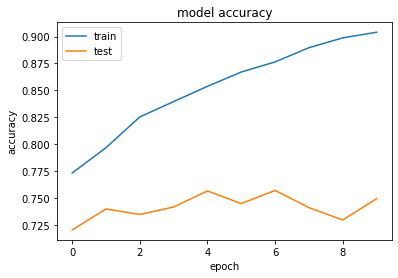

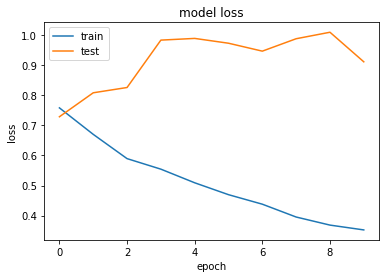

In [29]:
# Plot training statistics

# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')

plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
pred_proba = model.predict(train_data.batch(128))
pred = np.argmax(pred_proba, axis=1)

In [31]:
from sklearn.metrics import accuracy_score
print(classification_report(train_targets, pred))

              precision    recall  f1-score   support

         0.0       0.92      0.84      0.88    182498
         1.0       0.73      0.83      0.77     68178
         2.0       0.65      0.84      0.74     16023

    accuracy                           0.84    266699
   macro avg       0.77      0.84      0.80    266699
weighted avg       0.85      0.84      0.84    266699



# Post processing

# Evaluation

In [32]:
pred_proba = model.predict(test_data.batch(128))
pred = np.argmax(pred_proba, axis=1)

In [33]:
print(classification_report(test_targets, pred))

              precision    recall  f1-score   support

         0.0       0.89      0.77      0.83     64314
         1.0       0.62      0.64      0.63     15557
         2.0       0.27      0.85      0.41      3828

    accuracy                           0.75     83699
   macro avg       0.59      0.75      0.62     83699
weighted avg       0.81      0.75      0.77     83699



In [34]:
x_scale = np.linspace(0, 1, len(test_targets[2000:5000]))

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_scale, y=test_targets[2000:5000], mode='markers+lines', name='target'))
fig.add_trace(go.Scatter(x=x_scale, y=pred[2000:5000], mode='markers+lines', name='prediction'))

fig.show()